### Synthetic correlations with VAEs - Training

Simulating correlation matrices for financial assets lacks a universally accepted approach. This project explores the use of Variational Auto-Encoders (VAEs) to generate matrices that adhere to commonly observed correlation properties. Our focus is specifically on correlations among equity indices.

One notable aspect of our approach is the potential for explainability regarding how the correlation matrix may change over time—a desirable feature for financial applications.

The data utilized in our study is sourced from Datastream.

#### Example Illustration: Italian Default Rates

In this repository, we provide an example employing other data, that are freely available. The data, obtained from https://infostat.bancaditalia.it/, pertains to Italian default rates. We employ a spline method for data elaboration in this instance. Feel free to explore and adapt our methodology for your own research and applications.

Import some packages.

In [65]:
import torch
from torch.utils.data import BatchSampler, SequentialSampler, RandomSampler
import torch.nn as nn
import torch.nn.functional as F
import os
import torchvision
import torch.optim as optim
import argparse
import matplotlib
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from tqdm import tqdm
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import save_image
matplotlib.style.use('ggplot')
from torch.utils.data import Dataset
from torch.utils.data import random_split
import pandas
import numpy as np
import pickle
import seaborn as sns
import random

Define a linear VAE that squeezes from 32x32 to 2x2 and re-expands from 2x1 to 32x32.

In [66]:
FEATURES = 2
DIM_MAT = 32 # NOTE: the number of columns of the dataset. In our paper 44, here we use bankit data with 32 columns

class LinearVAE(nn.Module):
    def __init__(self):
        super(LinearVAE, self).__init__()
 
        # encoder
        self.enc1 = nn.Linear(in_features= (DIM_MAT) * (DIM_MAT), out_features=512)
        self.enc2 = nn.Linear(in_features=512, out_features=250)
        self.enc3 = nn.Linear(in_features=250, out_features=FEATURES*2)
 
        # decoder 
        self.dec1 = nn.Linear(in_features=FEATURES, out_features=250)
        self.dec2 = nn.Linear(in_features=250, out_features=512)
        self.dec3 = nn.Linear(in_features=512, out_features= (DIM_MAT) * (DIM_MAT))
   
    def reparameterize(self, mu, log_var):
        #param mu: mean from the encoder's latent space
        #param log_var: log var from the encoder's latent space
        
        std = torch.exp(0.5*log_var) # standard deviation
        eps = torch.randn_like(std) # `randn_like` random number with the same size of the input
        sample = mu + (eps * std) # sampling as if coming from the input space
        return sample
 
    def forward(self, x):
        # encoding
        x = F.relu(self.enc1(x)) #relu activation on first encoder
        x = F.relu(self.enc2(x)) #relu activation on second encoder
        x = self.enc3(x).view(-1, 2, FEATURES)  #apply 3th encoder without activation function (view change the dimensions)
        # get `mu` and `log_var`
        mu = x[:, 0, :] # the first feature values as mean
        log_var = x[:, 1, :] # the other feature values as variance
        # get the latent vector through reparameterization
        z = self.reparameterize(mu, log_var)
 
        # decoding
        x = F.relu(self.dec1(z))
        x = F.relu(self.dec2(x))
        reconstruction = torch.sigmoid(self.dec3(x))
        return reconstruction, mu, log_var
    


Set the learning parameters.

In [67]:
LR = 0.0001 # learning rate
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Define a Dataset object that provides matrices.

In [68]:
def minmaxscaler(x): # rescale array in [0, 1]
    return (x - x.min()) / (x.max() - x.min())


class SlicedDataset(Dataset):
    
    def __init__(self, csv_file, minmax, windowsize):
        self.data = np.genfromtxt(csv_file, delimiter = ';')[1:, 1:] # drop row and column names
        if minmax:
            self.data = np.apply_along_axis(minmaxscaler, 1, self.data)
        
        self.data = torch.as_tensor(self.data).float()
    
        self.windowsize = windowsize
        self.nrow = self.data.shape[0]
                
        if self.windowsize > self.nrow:
            raise Exception('Window size must not be larger than number of data rows.')
        
    def __getitem__(self, id_slice):
        # NOTE: by 'item' we mean 'slice' of length windowsize
        max_id = self.nrow - self.windowsize
        if id_slice > max_id:
            raise Exception('Non-existing slice selected.')
        return self.data[id_slice:(id_slice + self.windowsize), :]
    
    def __len__(self):
        return self.nrow - self.windowsize + 1 # because it is the number of possible items (i.e. slices)

Import returns of equity indices into a Dataset that returns "slices", i.e. matrices.

Length of matrices = W.

Possibly, rescale them in [0, 1].

In [6]:
W = 100 # size of the window (employed to compute the correlations)

### Load data from datastream

In [7]:
dati_scal = SlicedDataset('input.csv', minmax = True, windowsize = W)
dati_noscal = SlicedDataset('input.csv', minmax = False, windowsize = W)

In [8]:
x = np.genfromtxt('input.csv', delimiter = ';')[1:, 1:]
x.shape

(217, 32)

N: number of quotations

I: number of indices

W: length of window

From a SlicedDataset, create a DataLoader that generates N-W+1 historical matrices (as tensors), each one of dimension WxI (100 dates, 44 indices).

In [9]:
N = x.shape[0]
I = x.shape[1]

In [10]:
N - W + 1

118

In [11]:
returns_loader_noscal = DataLoader(dati_noscal, batch_size = N-W+1, shuffle = True)
batch_iter = iter(returns_loader_noscal)
next(batch_iter).size()


torch.Size([118, 100, 32])

From a SlicedDataset, create a DataLoader that generates 1 historical matrix (as tensor), of dimension W x I. Typically: (100 dates, 44 indices).

The matrices are shuffled, i.e. iterating over the returns_loader does not give consecutive periods.

In [12]:
#create a db with sampling matrices
returns_loader_scal = DataLoader(dati_scal, batch_size=1, shuffle=True)

If batch_size is 1, the loader can be iterated N-W+1 times.

In [13]:
next(iter(returns_loader_scal))

tensor([[[0.0000, 0.6694, 0.7008,  ..., 0.2910, 0.2643, 0.4400],
         [0.0973, 0.5263, 0.6285,  ..., 0.2463, 0.2441, 0.4426],
         [0.2741, 0.3537, 0.4860,  ..., 0.2498, 0.2701, 0.4255],
         ...,
         [0.0407, 0.6075, 0.4338,  ..., 0.4896, 0.2025, 0.4765],
         [0.1169, 0.7843, 0.4307,  ..., 0.5587, 0.1623, 0.5792],
         [0.1544, 0.7975, 0.3666,  ..., 0.5276, 0.1103, 0.5691]]])

Compute N-W+1 correlation matrices (dimension: I x I) and collect them in a list. Each correlation matrix is stored as a PyTorch tensor.

In [14]:
returns_loader_noscal = DataLoader(dati_noscal, batch_size = 1, shuffle = True)
corr_mat_list = []
iterat = iter(returns_loader_noscal)
for i in range(N - W + 1):
    data = next(iterat)[0].transpose(0, 1) # obtain a matrix IxW (example: 44x100)
    corr_mat_list.append(data.corrcoef())

In [15]:
print(corr_mat_list[10])
print("Length of corr_mat_list: ", len(corr_mat_list))

tensor([[1.0000, 0.8622, 0.8186,  ..., 0.7561, 0.7847, 0.8567],
        [0.8622, 1.0000, 0.9385,  ..., 0.9001, 0.9121, 0.9420],
        [0.8186, 0.9385, 1.0000,  ..., 0.9477, 0.9739, 0.9755],
        ...,
        [0.7561, 0.9001, 0.9477,  ..., 1.0000, 0.9797, 0.9455],
        [0.7847, 0.9121, 0.9739,  ..., 0.9797, 1.0000, 0.9719],
        [0.8567, 0.9420, 0.9755,  ..., 0.9455, 0.9719, 1.0000]])
Length of corr_mat_list:  118


Define a subclass of Dataset that contains all the N-W+1 correlation tensors ("Dataset" is an abstract class, so it must be overridden).

In [16]:
class corr_Dataset(Dataset):
    def __init__(self, data):
        self.data = data
        
    def __getitem__(self, index):
        x = self.data[index]
        return x
    
    def __len__(self):
        return len(self.data)

Split the N-W+1 correlation matrices in a training dataset and a validation dataset.

In [17]:
TRAIN_PCT = .7
dataset = corr_Dataset(corr_mat_list)
n_training = round(TRAIN_PCT * (N-W+1)) # set a percentage of the matrices to training
n_validation = N-W+1 - n_training
print("training matrices: ", n_training)
print("validation matrices: ", n_validation)

training matrices:  83
validation matrices:  35


## Set a seed to fix the training and validation dataset (for comparison with other models)

In [18]:
train_data, val_data = random_split(dataset, [n_training, n_validation], generator=torch.Generator().manual_seed(42))

In [19]:
a, b = random_split(range(N - W + 1), [n_training, n_validation], generator=torch.Generator().manual_seed(42))

Create DataLoaders that generate a matrix from the training set and validation set respectively. Training is shuffled, validation is in chronological order.

In [20]:
BATCH_SIZE = 1
train_loader = DataLoader(train_data, batch_size = BATCH_SIZE, shuffle = True)
val_loader = DataLoader(val_data, batch_size = BATCH_SIZE, shuffle = False)

In [21]:
next(iter(train_loader)).size()

torch.Size([1, 32, 32])

Instantiate a VAE on the CPU.
Instantiate also an optimizer and a loss criterion.

In [22]:
model = LinearVAE().to(device)
optimizer = optim.Adam(model.parameters(), lr = LR)
criterion = nn.MSELoss(reduction = 'sum')
print(model)

LinearVAE(
  (enc1): Linear(in_features=1024, out_features=512, bias=True)
  (enc2): Linear(in_features=512, out_features=250, bias=True)
  (enc3): Linear(in_features=250, out_features=4, bias=True)
  (dec1): Linear(in_features=2, out_features=250, bias=True)
  (dec2): Linear(in_features=250, out_features=512, bias=True)
  (dec3): Linear(in_features=512, out_features=1024, bias=True)
)


Define the loss function, using the Kullback-Leibler divergence.

In [23]:
def final_loss(mse_loss, mu, logvar, beta):
    """
    This function will add the reconstruction loss (MSELoss) and the 
    KL-Divergence.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    :param MSE_loss: recontruction loss
    :param mu: the mean from the latent vector
    :param logvar: log variance from the latent vector
    """
    MSE = mse_loss
    KLD = - 0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + beta * KLD

Define a fit function.

In [24]:
def fit(model, dataloader, beta):
    model.train() # set model in training mode: parameters get updated
    running_loss = 0.0
  
    for i, data in tqdm(enumerate(dataloader), total = int(len(dataloader) / dataloader.batch_size)):
        # data is a tensor 1xIxI (e.g. 1x44x44)
        data = data.to(device)
        data = data.view(data.size(0), -1) # reshape of input for linear layer, now data is a tensor 1xI^2 (e.g. 1x1932)
        
        optimizer.zero_grad() # reset del gradiente
        reconstruction, mu, logvar = model(data)
        
        mse_loss = criterion(reconstruction, data)
        
        loss = final_loss(mse_loss, mu, logvar, beta)
        running_loss += loss.item()
        loss.backward() # backpropagation del gradiente
        optimizer.step() # update dei parametri
    
    train_loss = running_loss / len(dataloader)
    return train_loss

Define a validation function.

In [25]:
def validate(model, dataloader, beta):
    model.eval()  # set model in validating mode: parameters do not get updated (so the gradient is not needed)
    running_loss = 0.0
    with torch.no_grad():  
        for i, data in tqdm(enumerate(dataloader), total = int(len(dataloader) / dataloader.batch_size)):
            data = data.to(device)
            data = data.view(data.size(0), -1) # reshape of input for linear layer, now data is a tensor 1xI^2 (e.g. 1x1932)
            reconstruction, mu, logvar = model(data)
            mse_loss = criterion(reconstruction, data)
            loss = final_loss(mse_loss, mu, logvar, beta)
            running_loss += loss.item()
                
    val_loss = running_loss / len(dataloader)
    return val_loss

### Perform a loop of training and validation, saving the training loss and validation loss to check convergence.

In [26]:
EPOCHS = 80
beta = 0.1 #parametro per regolarizzare lo spazio latente
train_loss = []
val_loss = []
for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1} of {EPOCHS}")
    train_epoch_loss = fit(model, train_loader, beta)
    val_epoch_loss = validate(model, val_loader, beta)
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Val Loss: {val_epoch_loss:.4f}")

Epoch 1 of 80


100%|██████████| 35/35 [00:00<00:00, 268.39it/s]


Train Loss: 53.9359
Val Loss: 16.2104
Epoch 2 of 80


100%|██████████| 35/35 [00:00<00:00, 174.00it/s]


Train Loss: 14.6507
Val Loss: 15.7541
Epoch 3 of 80


100%|██████████| 35/35 [00:00<00:00, 1282.68it/s]


Train Loss: 13.6282
Val Loss: 14.1654
Epoch 4 of 80


100%|██████████| 35/35 [00:00<00:00, 817.18it/s]


Train Loss: 13.1428
Val Loss: 13.0716
Epoch 5 of 80


100%|██████████| 35/35 [00:00<00:00, 1333.34it/s]


Train Loss: 12.5200
Val Loss: 11.7108
Epoch 6 of 80


 14%|█▍        | 12/83 [00:01<00:07,  9.59it/s]


KeyboardInterrupt: 

Visualize the convergence.

In [ ]:
plt.plot(train_loss, label = "training loss")
plt.plot(val_loss, label = "validation loss")
plt.legend()

Save the trained model to a file.

In [ ]:
#salva lo state dict del modello
PATH = os.getcwd()
torch.save(model.state_dict(), "github_model_80epochs_beta_01_SEED.pth")

### Load a trained model

In [27]:
model.load_state_dict(torch.load('github_model_80epochs_beta_01_SEED.pth'))

<All keys matched successfully>

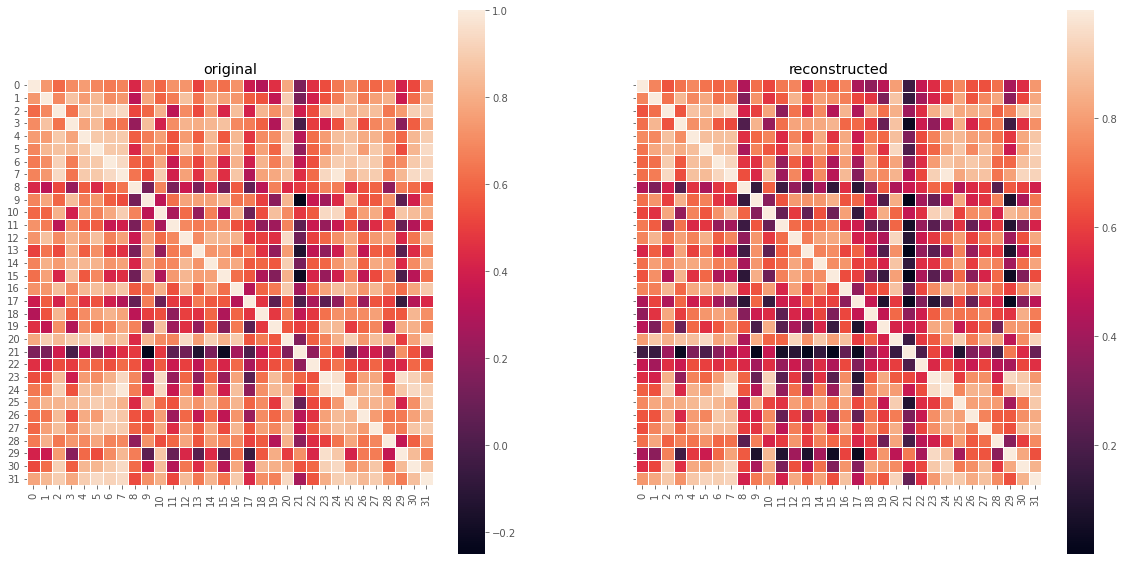

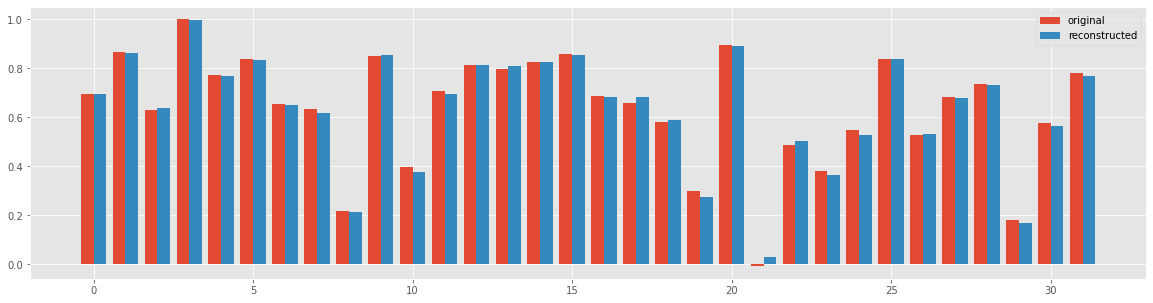

In [30]:
data = next(iter(train_loader))
data = data.to(device)           
data_ = data.view(data.size(0), -1)
reconstruction, mu, logvar = model(data_)
f,(ax1,ax2) = plt.subplots(1, 2, sharey=True, figsize =(20, 10))
g1 = sns.heatmap(data.view(DIM_MAT, DIM_MAT), linewidth=0.5,cbar=True,ax=ax1, square=True)
g1.set_ylabel('')
g1.set_xlabel('')
g1.set_title("original")
g2 = sns.heatmap(reconstruction.view(DIM_MAT,DIM_MAT).detach().numpy(), linewidth=0.5,cbar=True,ax=ax2, square=True)
g2.set_ylabel('')
g2.set_xlabel('')
g2.set_title("reconstructed")
plt.show()
x_axis = np.arange(DIM_MAT)
a_row = random.randrange(I)
plt.figure(figsize=(20, 5))
plt.bar(x_axis-0.2, data.view(DIM_MAT,DIM_MAT).detach().numpy()[a_row,:], width=0.4, label = "original")
plt.bar(x_axis+0.2, reconstruction.view(DIM_MAT,DIM_MAT).detach().numpy()[a_row,:],width=0.4, label = "reconstructed")
plt.legend()
plt.show()

In [47]:
corr_in = data.view(DIM_MAT,DIM_MAT).detach().numpy()[a_row,:]
corr_out = reconstruction.view(DIM_MAT,DIM_MAT).detach().numpy()[a_row,:]
corr_in

array([0.82687926, 0.93905824, 0.9155761 , 0.9657555 , 0.93628275,
       0.97518975, 0.9133382 , 0.9291074 , 0.51942104, 0.8967742 ,
       0.82774514, 0.7421882 , 0.9802523 , 0.85348535, 0.88592064,
       0.8787133 , 0.94510794, 0.7465406 , 0.8482268 , 0.61003363,
       0.9999999 , 0.2861034 , 0.6603946 , 0.82227737, 0.8975231 ,
       0.96480465, 0.8474368 , 0.93341035, 0.921636  , 0.677835  ,
       0.86335415, 0.9663659 ], dtype=float32)

detach().numpy() trasforma 1 in 0.999999999

100%|██████████| 83/83 [00:00<00:00, 957.05it/s]


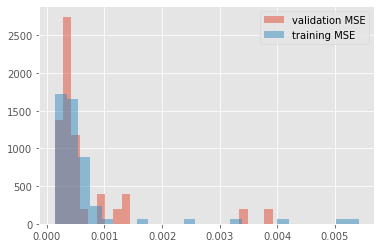

In [48]:
model.eval()  
running_loss = 0.0
item_loss = []
mu_outsample, std_outsample = [[], []]

criterion2 = nn.MSELoss(reduction = 'mean')

with torch.no_grad():   
    for i, data in tqdm(enumerate(val_loader), total=int(len(val_data)/val_loader.batch_size)):
        #data, _ = data
        data = data.to(device)

        data = data.view(data.size(0), -1)
        reconstruction, mu, logvar = model(data)

      #  reconstruction = reconstruction.view( -1)
        mu_outsample.append(mu)
        std = torch.exp(0.5*logvar)
        std_outsample.append(std)

        mse_loss = criterion2(reconstruction, data)
       # print("mse_loss = ", mse_loss)
        #loss = final_loss(mse_loss, mu, logvar, beta)
        loss = mse_loss 

        #print("runing_loss = ", running_loss)
        item_loss.append(loss)

tens_mu_outsample = torch.stack(mu_outsample)
tens_std_outsample = torch.stack(std_outsample)

item_loss_insample = []
mu_insample, std_insample =  [[], []]
with torch.no_grad():   
    for i, data in tqdm(enumerate(train_loader), total=int(len(train_data)/train_loader.batch_size)):
        #data, _ = data
        data = data.to(device)

        data = data.view(data.size(0), -1)
        reconstruction, mu, logvar = model(data)

      #  reconstruction = reconstruction.view( -1)
        mu_insample.append(mu)
        std = torch.exp(0.5*logvar)
        std_insample.append(std)
        mse_loss = criterion2(reconstruction, data)
       # print("mse_loss = ", mse_loss)
        #loss = final_loss(mse_loss, mu, logvar, beta)
        loss = mse_loss 

        #print("runing_loss = ", running_loss)
        item_loss_insample.append(loss)

plt.hist(item_loss, bins=26, alpha=0.5, label = 'validation MSE', density=True)            
plt.hist(item_loss_insample, bins=26, alpha=0.5, label = 'training MSE', density=True)
plt.legend()
plt.show()

In [49]:
# Convert the item_loss and item_loss_insample to numpy arrays
item_loss_np = np.array(item_loss)
item_loss_insample_np = np.array(item_loss_insample)

# Calculate mean, median, and std for validation loss
mean_loss = np.mean(item_loss_np)
median_loss = np.median(item_loss_np)
std_loss = np.std(item_loss_np)

# Calculate mean, median, and std for training loss
mean_loss_insample = np.mean(item_loss_insample_np)
median_loss_insample = np.median(item_loss_insample_np)
std_loss_insample = np.std(item_loss_insample_np)

# Print the results in a formatted manner
print("Validation Loss Statistics:")
print(f"  Mean:            {mean_loss:.4f}")
print(f"  Median:          {median_loss:.4f}")
print(f"  Standard Deviation: {std_loss:.4f}")

print("\nTraining Loss Statistics:")
print(f"  Mean:            {mean_loss_insample:.4f}")
print(f"  Median:          {median_loss_insample:.4f}")
print(f"  Standard Deviation: {std_loss_insample:.4f}")

Validation Loss Statistics:
  Mean:            0.0007
  Median:          0.0004
  Standard Deviation: 0.0008

Training Loss Statistics:
  Mean:            0.0007
  Median:          0.0004
  Standard Deviation: 0.0009
